# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
# help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(ngram_range=(1,2))
#         hv = HashingVectorizer(n_features=2**18, alternate_sign=False, stop_words='english', ngram_range=(1, 2),lowercase=True)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
#         transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/yaogeezi/Desktop/ml_master/final_assignment_1/moviereviews_train.tsv', my_random_seed=6)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1513832)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 5167, 'TN': 4858, 'FP': 5152, 'FN': 4823, 'Accuracy': 0.50125, 'Precision': 0.5007268146138192, 'Recall': 0.5172172172172173, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1000000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 7965, 'TN': 7241, 'FP': 2769, 'FN': 2025, 'Accuracy': 0.7603, 'Precision': 0.7420346562325322, 'Recall': 0.7972972972972973, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

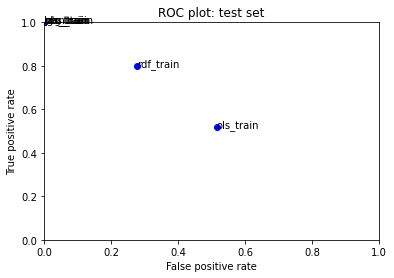

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
9
This was without a doubt the worst thing I have ever spent money on. I feel dirty for admitting that I rented this 'movie' and actually paid money to see it. This does not even rate trash. No no. This is the juice that collects at the bottom of industrial dumpsters located in particularly foul neighborhoods after an extraordinarily humid summer. To call it trash would be to degrade trash everywhere. It was so bad I felt I had to register at IMDb and warn my fellow man. This luvahire character claims this movie is great. One has to question his grasp on reality. Let's take some of his comments and analyze them.<br /><br />\The actor who played Ricky (I forgot his name) did a VERY good job.\"<br /><br />I see. Well, if the director envisioned his audience cringing and wincing at every sentence uttered by Ricky or alternately bursting into uncontrollable laughter at moments when most directors would want a more somber reaction from their viewers, then yes; R

4338
I really must watch a good movie soon, because it seems every other entry or so is something that I despise. However my history speaks, I must not tell a lie. Bobby Deerfield and everything about it sucks big green banana peels. I never thought that I would see a film thud as thunderously as this one did. Al Pacino isn't acting in this film: he's posing. There are many, many scenes of his character, who is a race car driver, just staring at the camera. He's perfectly awful. Marthe Keller is just as bad. These two are supposed to be in a love affair, and there is simply no chemistry whatsoever. Sydney Pollack directed this film? There's no trace of the genius behind Tootsie here. Is this the same man I cheered for in Eyes Wide Shut? I can hardly believe it. Save yourself a horrible movie experience. Run, don't walk, away from Bobby Deerfield.
* * * * * * * * * 
4361
Perhaps not my genre but plot was horrible as was acting by Nancy Allen and Linda Farentino. C. Thomas also seemed un

7430
This movie was absolute torture. First of all, it's a whopping 4+ hours long! True, the Kargil war may have had several points that were captured and fought for, but every single one of those battles need not have been shown. So maybe this is a documentary, not a commercial film as advertised. Sure didn't seem like it, as enough background information was not given and there were some flaws. The battle sequences were so poorly executed. I am terribly disappointed from the man who gave well done sequences in Border. Each battle was the exact same as the previous. It was so predictable. (This might be a spoiler.) The whole army marches uphill, five or so soldiers curse five thousand times each (they also use the same cussword every time), one of the lead actors is shot, someone yells for a stretcher, the actor says, \No, don't get a stretcher. That will take 6 men from the battalion,\" and then an actor dies. That exact same thing happens over and over and over again. Oh, and the so

10655
You'll notice that the chemist, who appears in two scenes and gets to speak, is played by Stephen King. \Don't give up your day job\" is the standard thing to say, but that's not fair. King acquits himself reasonably well: he's no worse than any other member of the cast, and better than most. The story, on the other hand, is pure rubbish. Please, give up your day job.<br /><br />Never have I seen so many dreadful performances - of which the lead actor's (the LEAD ACTOR'S!) is probably the worst - gathered together in the one film. Everyone acts hammily, but not in any entertaining way; they all somehow manage to go over-the-top without expending, or manifesting, energy. I blame screenwriter/director Tom Holland. It can't be that ALL the actors are REALLY this bad. What are the odds against that? Admittedly, I've never heard of any of them before, but still, I don't think I could walk into a talent agency and walk out with this many bad performers if I tried: ONE actor, despite my

13959
It is only Robert De Niro film which I really hates. It is stupid film with horrible acting (of course not De Niro). For me, Brian De Palma must do his mafia films as always like Scarface (1983) or The Untouchables (1987). I also loved De Palma's Mission: Impossible (1996). De Niro worked with Palma two different times too, Greetings and The Wedding Party. I though that The Wedding Party was OK too (I didn't watch Greetings). <br /><br />Screenplay is really bad and unfunny. There are no any scene where I can smile for even one time. Film lost a chance to be a funny style even a little bit in a \Be Black baby\" scene and also I don't like the scene where a guy's sexual organ appeared. So, it is one of the worst film I have ever seen! just worst. I hate that."
* * * * * * * * * 
13999
Because that's all she does through out this whole movie,is get naked for no good reason.When Tarzan is bitten by a snake,she suddenly removes her clothes.Since when is a boa constrictor poisonous?Ho

17212
Just so that you fellow movie fans get the point about this film, I decided to write another review. I missed a few things out last time...<br /><br />First, the script. Second, the acting. Third, Jesus Christ what were they thinking making a piece of garbage like this and then expecting us to enjoy it when there are no redeeming features whatsoever from beginning to end except when Joseph Fiennes finally gets blown away in a very unexciting climax!!!<br /><br />I can't believe I wasted my money on this when I could have given it to a homeless person or a busker or SOMETHING!<br /><br />Are you getting the picture?
* * * * * * * * * 
17361
The title creatures wreak havoc at a peaceful little desert town. That's basically the whole plot for this film, and while the scenes devoted to the Munchies themselves are somewhat fun (in a lowbrow kind of way), all the rest is just filler, and bad filler at that. From the \hero\", who is a painful Woody Allen wannabe, to the ultra-dumb town 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1259, 'TN': 1204, 'FP': 1286, 'FN': 1251, 'Accuracy': 0.4926, 'Precision': 0.49469548133595287, 'Recall': 0.501593625498008, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2120, 'TN': 2070, 'FP': 420, 'FN': 390, 'Accuracy': 0.838, 'Precision': 0.8346456692913385, 'Recall': 0.8446215139442231, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2096, 'TN': 2130, 'FP': 360, 'FN': 414, 'Accuracy': 0.8452, 'Precision': 0.8534201954397395, 'Recall': 0.8350597609561753, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2059, 'TN': 2148, 'FP': 342, 'FN': 451, 'Accuracy': 0.8414, 'Precision': 0.8575593502707205, 'Recall': 0.8203187250996016, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2104, 'TN': 2127, 'FP': 363, 'FN': 406, 'Accuracy': 0.8462, 'Precision': 0.852857721929469, 'Recall': 0.8382470119521912, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2283, 'TN': 2200, 'FP': 290, 'FN': 227, 'Accuracy': 0.8966, 'Precision': 0.8872910998834046, 'Recall': 0.9095617529880478, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1955, 'TN': 1753, 'FP': 737, 'FN': 555, 'Accuracy': 0.7416, 'Precision': 0.7262258543833581, 'Recall': 0.7788844621513944, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

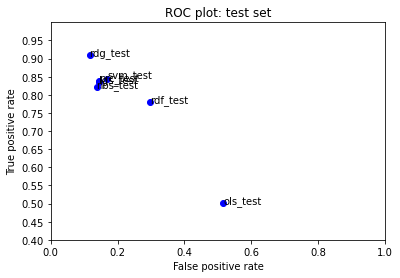

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=6, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 1513832)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49076


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_second_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation